# Intro to Spark
Ejemplos prácticos
---

Crear una sesión de Spark

In [1]:
### Con SparkSession
from pyspark.sql import SparkSession

# crear sesión

spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("local[*]") \
        .getOrCreate()

In [ ]:
## parar la sesión
spark.stop()

In [ ]:
## Con SparkContext y SQLContext
from pyspark import SparkContext
from pyspark import SQLContext

## crear el contexto
sc = SparkContext("local[*]", "pyspark_df")
ss = SQLContext(sc)


In [ ]:
### parar el contexto
sc.stop()

---

In [2]:
### Crear un Dataframe a partir de un csv
dfs_flights = spark.read.option("inferSchema", "true").option("header", "true").csv('data/2015-summary.csv')

In [3]:
### Inspeccionar el Dataframe
dfs_flights.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: integer (nullable = true)



In [4]:
## Renombrar la cplumna count

dfs_flights = dfs_flights.withColumnRenamed('count', 'NumFlights')

In [5]:
dfs_flights.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- NumFlights: integer (nullable = true)



In [6]:
### Ordenar según la columna count
dfs_fligths_sorted = dfs_flights.sort("NumFlights", ascending=False) # no tarda nada porque es una transformación

In [7]:
dfs_fligths_sorted.show(10) ## al hacerle el show realiza el sort y nos devuelve los 10 primeros

+-----------------+-------------------+----------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|NumFlights|
+-----------------+-------------------+----------+
|    United States|      United States|    370002|
|    United States|             Canada|      8483|
|           Canada|      United States|      8399|
|    United States|             Mexico|      7187|
|           Mexico|      United States|      7140|
|   United Kingdom|      United States|      2025|
|    United States|     United Kingdom|      1970|
|            Japan|      United States|      1548|
|    United States|              Japan|      1496|
|          Germany|      United States|      1468|
+-----------------+-------------------+----------+
only showing top 10 rows



In [8]:
### group by
count_per_dest = dfs_flights.groupBy("DEST_COUNTRY_NAME").sum()

In [9]:
### Enseña el dataframe count_per_dest
count_per_dest.show()

+--------------------+---------------+
|   DEST_COUNTRY_NAME|sum(NumFlights)|
+--------------------+---------------+
|            Anguilla|             41|
|              Russia|            176|
|            Paraguay|             60|
|             Senegal|             40|
|              Sweden|            118|
|            Kiribati|             26|
|              Guyana|             64|
|         Philippines|            134|
|            Djibouti|              1|
|            Malaysia|              2|
|           Singapore|              3|
|                Fiji|             24|
|              Turkey|            138|
|                Iraq|              1|
|             Germany|           1468|
|              Jordan|             44|
|               Palau|             30|
|Turks and Caicos ...|            230|
|              France|            935|
|              Greece|             30|
+--------------------+---------------+
only showing top 20 rows



In [10]:
## Renombra la columna sum(NumFlights)
count_per_dest = count_per_dest.withColumnRenamed('sum(NumFlights)', 'total_flights')
count_per_dest.show()

+--------------------+-------------+
|   DEST_COUNTRY_NAME|total_flights|
+--------------------+-------------+
|            Anguilla|           41|
|              Russia|          176|
|            Paraguay|           60|
|             Senegal|           40|
|              Sweden|          118|
|            Kiribati|           26|
|              Guyana|           64|
|         Philippines|          134|
|            Djibouti|            1|
|            Malaysia|            2|
|           Singapore|            3|
|                Fiji|           24|
|              Turkey|          138|
|                Iraq|            1|
|             Germany|         1468|
|              Jordan|           44|
|               Palau|           30|
|Turks and Caicos ...|          230|
|              France|          935|
|              Greece|           30|
+--------------------+-------------+
only showing top 20 rows



In [11]:
### Ordena por número de vuelos
most_flights = count_per_dest.sort('total_flights', ascending=False)

In [12]:
### Top 5
most_flights.show(5)

+-----------------+-------------+
|DEST_COUNTRY_NAME|total_flights|
+-----------------+-------------+
|    United States|       411352|
|           Canada|         8399|
|           Mexico|         7140|
|   United Kingdom|         2025|
|            Japan|         1548|
+-----------------+-------------+
only showing top 5 rows



### Querying the data with SQL

In [14]:
# Create temp table

dfs_flights.createOrReplaceTempView("flights_2015")

In [19]:
query = """
SELECT *
FROM flights_2015
ORDER BY NumFlights DESC
LIMIT 10
"""

In [20]:
query_result = spark.sql(query)

In [21]:
type(query_result)

pyspark.sql.dataframe.DataFrame

In [22]:
query_result.show()

+-----------------+-------------------+----------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|NumFlights|
+-----------------+-------------------+----------+
|    United States|      United States|    370002|
|    United States|             Canada|      8483|
|           Canada|      United States|      8399|
|    United States|             Mexico|      7187|
|           Mexico|      United States|      7140|
|   United Kingdom|      United States|      2025|
|    United States|     United Kingdom|      1970|
|            Japan|      United States|      1548|
|    United States|              Japan|      1496|
|          Germany|      United States|      1468|
+-----------------+-------------------+----------+



In [ ]:
# Calcula el total de vuelos en función del destino y saca el destino más frecuente

## Funcionalidad dataframes

Muchas veces nos encontraremos con que queremos utilizar algua funcion integrada en los dataframes, cómo en pandas.

Para poder acceder a estas funciones, tendremos que importarlas de la librería

In [23]:
from pyspark.sql.functions import max

In [25]:
spark.sql("SELECT max(NumFlights) from flights_2015").take(1)

[Row(max(NumFlights)=370002)]

In [26]:
dfs_flights.select(max("NumFlights")).take(1)

[Row(max(NumFlights)=370002)]

### Intefración con pandas

In [27]:
import pandas as pd

In [28]:
df = dfs_flights.toPandas()

In [29]:
df.head()

,DEST_COUNTRY_NAME,ORIGIN_COUNTRY_NAME,NumFlights
0,United States,Romania,15
1,United States,Croatia,1
2,United States,Ireland,344
3,Egypt,United States,15
4,United States,India,62


In [30]:
df = dfs_flights.groupBy("DEST_COUNTRY_NAME").sum("NumFlights")\
           .withColumnRenamed("sum(NumFlights)", "destination_total")\
           .sort(desc("destination_total"))\
           .limit(10)\
           .toPandas()

NameError: name 'desc' is not defined

In [31]:
from pyspark.sql.functions import desc

df = dfs_flights.groupBy("DEST_COUNTRY_NAME").sum("NumFlights")\
           .withColumnRenamed("sum(NumFlights)", "destination_total")\
           .sort(desc("destination_total"))\
           .limit(10)\
           .toPandas()


In [32]:
%matplotlib inline

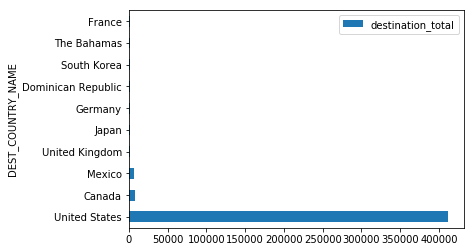

In [33]:
df.set_index('DEST_COUNTRY_NAME').plot(kind='barh')

In [34]:
## from pandas to SparkDataframe

df_test = spark.createDataFrame(df)

In [35]:
spark.stop()

## Ejercicio
---

Haz un análisis exploratorio del fichero 'data/201508_trip_data.csv' usando spark y plotea los resultados usando las funcionalidades de python

In [ ]:
## importa lo necesario para crear el entorno de spark

### Con SparkSession

# crear sesión


In [ ]:
## carga el fichero 'data/201508_trip_data.csv'
path = 'data/201508_trip_data.csv'

dfs_bikes = 

In [ ]:
# Imprime el esquema y las columnas del dfs_bikes



In [ ]:
## Haz una descripción de la columnas Duration del dfs_bikes
## En que unidades está la duración ?


In [ ]:
## Cual son las 5 estaciones más transitada?

most_frequent = 

In [ ]:
## Repite el ejercicio anterior usando SQL

## Cambia el nombre a la columna para que no tenga espacios
dfs_bikes = 
## Crea una tabla temporal

## Escribe una query sql que realice la tarea de antes
query = """

"""

most_frequent_sql = spark.sql(query)

In [ ]:
### Transform it to pandas and plot the result


In [ ]:
spark.stop()